In [1]:
import sys
sys.path.append( "/home/ljuusola/Projects/RL/SuttonBarto" )

from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import pandas as pd

from bandits.rewards import ConstantRewardGenerator, NormalNoiseRewardGenerator, ValueNoiseRewardGenerator
from bandits.policies import GreedyPolicy, EpsilonGreedyPolicy, SoftmaxStochasticPolicy
from bandits.quality_function import QualitySampleMean, QualityUCB, QualitySoftmaxGrad
from bandits.karm import KArmedBandit

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,15)

MAX_PRINT_TRIALS = 5
n_trials = 1000
k = 10
len_trial = 1000

parameters = [2**i for i in range( -7, 3 ) ]

### Epsilon Greedy versus UCB
policiesBase = defaultdict(defaultdict)
for param in parameters:
    policiesBase[param][ f"gradient" ] = SoftmaxStochasticPolicy( QualitySoftmaxGrad( k, alpha = param ) )
    policiesBase[param][ f"ucb" ]      = GreedyPolicy( QualityUCB( QualitySampleMean(k), c=param ) )
    policiesBase[param][ f"epsOpt"]    = EpsilonGreedyPolicy(0.1, QualitySampleMean( k, prior = np.ones( k ) * param ) )
    if 0 <= param <= 1:
        policiesBase[param][ f"eps"]   = EpsilonGreedyPolicy(param, QualitySampleMean( k ) )

policyNames = None
for param, polDict in policiesBase.items():
    if policyNames is None:
        policyNames = set ( polDict.keys() )
    else: 
        assert set( polDict.keys() ).issubset( policyNames ), f"{policyNames} != {set( polDict.keys() )}"
assert policyNames is not None and len( policyNames ) > 0
policyNames = list( sorted( policyNames ) )

rewardMeansExp = np.random.normal( 0, 1, size=(n_trials, k) )
meanRewardsExp = []
meanChoicesExp = []
for itrial in tqdm( range( n_trials ) ):
    meanRewards = pd.DataFrame( index = parameters, columns = policyNames )
    meanChoices = pd.DataFrame( index = parameters, columns = policyNames )
    rewardMeans = rewardMeansExp[itrial]
    rewardGenerators = [ ValueNoiseRewardGenerator(
                            valueGen=ConstantRewardGenerator(rm),
                            noiseGen=NormalNoiseRewardGenerator(0,1)
                        ) for rm in rewardMeans ]
    bandit = KArmedBandit( rewardGenerators )
    policies = deepcopy( policiesBase )
    curRewards = pd.DataFrame( index = parameters, columns = policyNames )
    curChoices = pd.DataFrame( index = parameters, columns = policyNames )
    if n_trials <= MAX_PRINT_TRIALS:
        print( np.array( [ r.get_value() for r in bandit.rewards ] ) )
    for i in range(len_trial):
        optimalArm = bandit.optimal_arm()
        for param, paramPolicies in policies.items():
            for name, policy in paramPolicies.items():
                arm = policy.choice()
                reward = bandit.query_arm( arm )
                policy.update( arm, reward )
                curRewards.loc[param, name] = reward
                curChoices.loc[param, name] = arm
        bandit.step()
        curChoices = (curChoices == optimalArm).astype( float )

        if i == 0: 
            meanRewards = curRewards.copy()
            meanChoices = curChoices.copy()
        else:
            meanRewards += (curRewards - meanRewards) / i
            meanChoices += (curChoices - meanChoices) / i
    meanRewardsExp.append( meanRewards )
    meanChoicesExp.append( meanChoices )

100%|██████████| 1000/1000 [44:10<00:00,  2.65s/it]


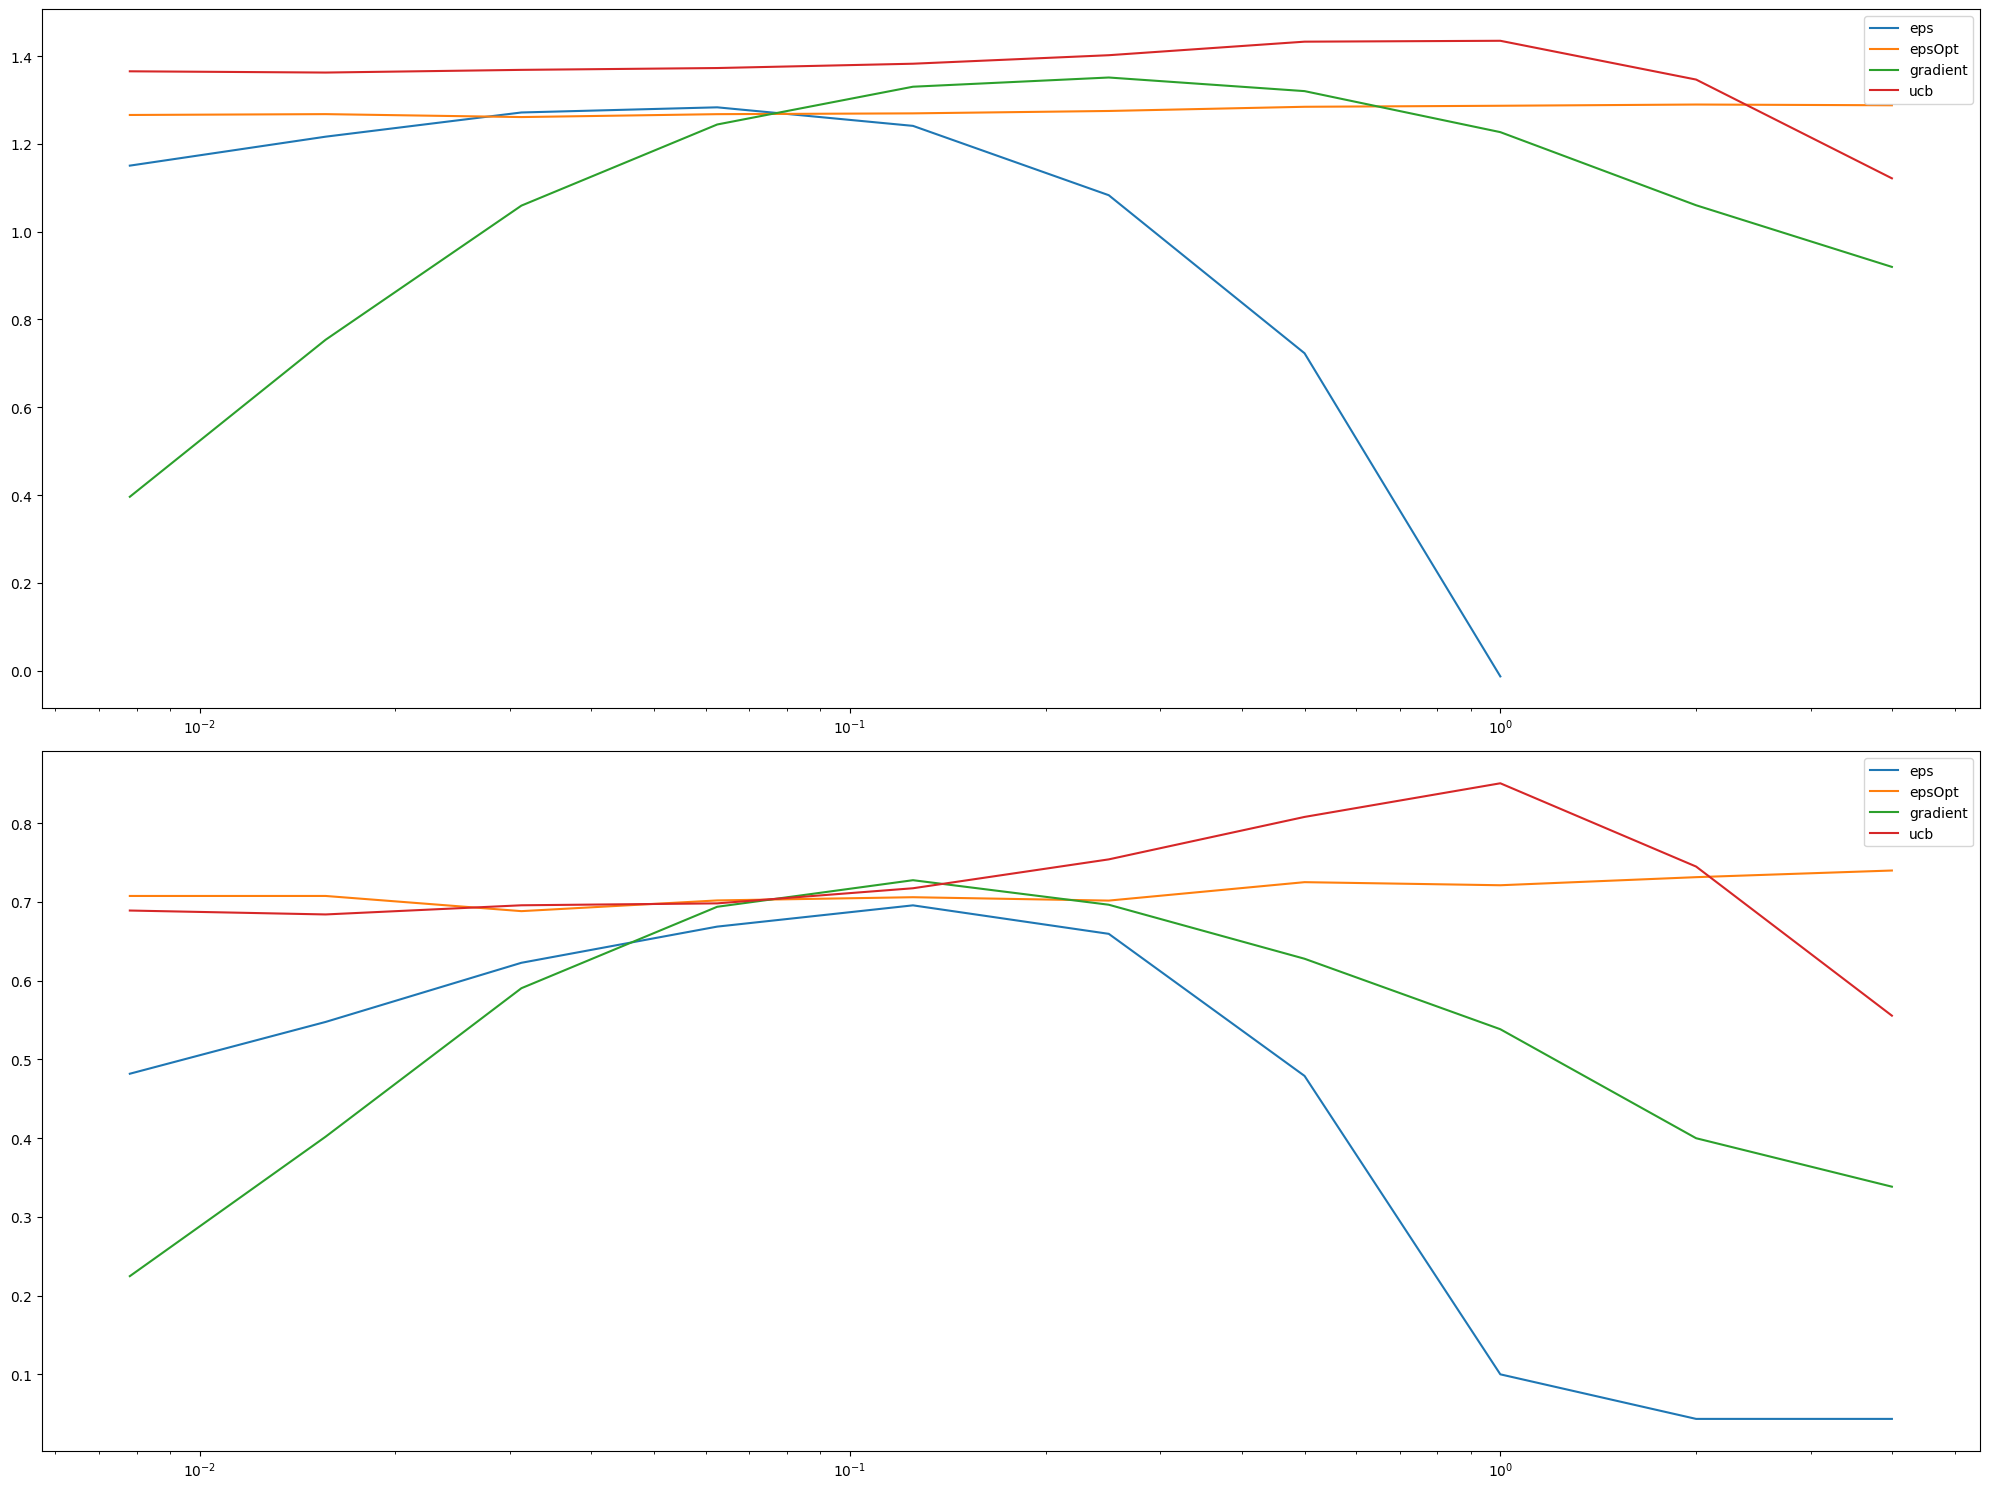

In [5]:
meanRewards = sum( meanRewardsExp ) / n_trials
meanChoices = sum( meanChoicesExp ) / n_trials

fig, axs = plt.subplots( nrows = 2 )
meanRewards.plot( kind = "line", logx=True, ax=axs[0], legend=True)
meanChoices.plot( kind = "line", logx=True, ax=axs[1])
fig.tight_layout()
plt.show()

eps 0.0078125 [-0.53558628  0.75398652  1.11687685  1.4944383   3.51100493]
eps 0.015625 [-0.43488764  0.80619105  1.17718694  1.58473646  3.50171986]
eps 0.03125 [-0.10780533  0.89293974  1.25635674  1.63580569  3.42507805]
eps 0.0625 [-0.25758631  0.89434474  1.26199509  1.64781068  3.31912349]
eps 0.125 [-0.132088    0.87889121  1.22735189  1.58695261  3.13227494]
eps 0.25 [-0.25938915  0.74702498  1.07548211  1.39843053  2.72513758]
eps 0.5 [-0.45160135  0.44710377  0.72889275  0.99283252  1.96879356]
eps 1.0 [-1.00703242 -0.22971987 -0.0088285   0.20489731  0.95698511]


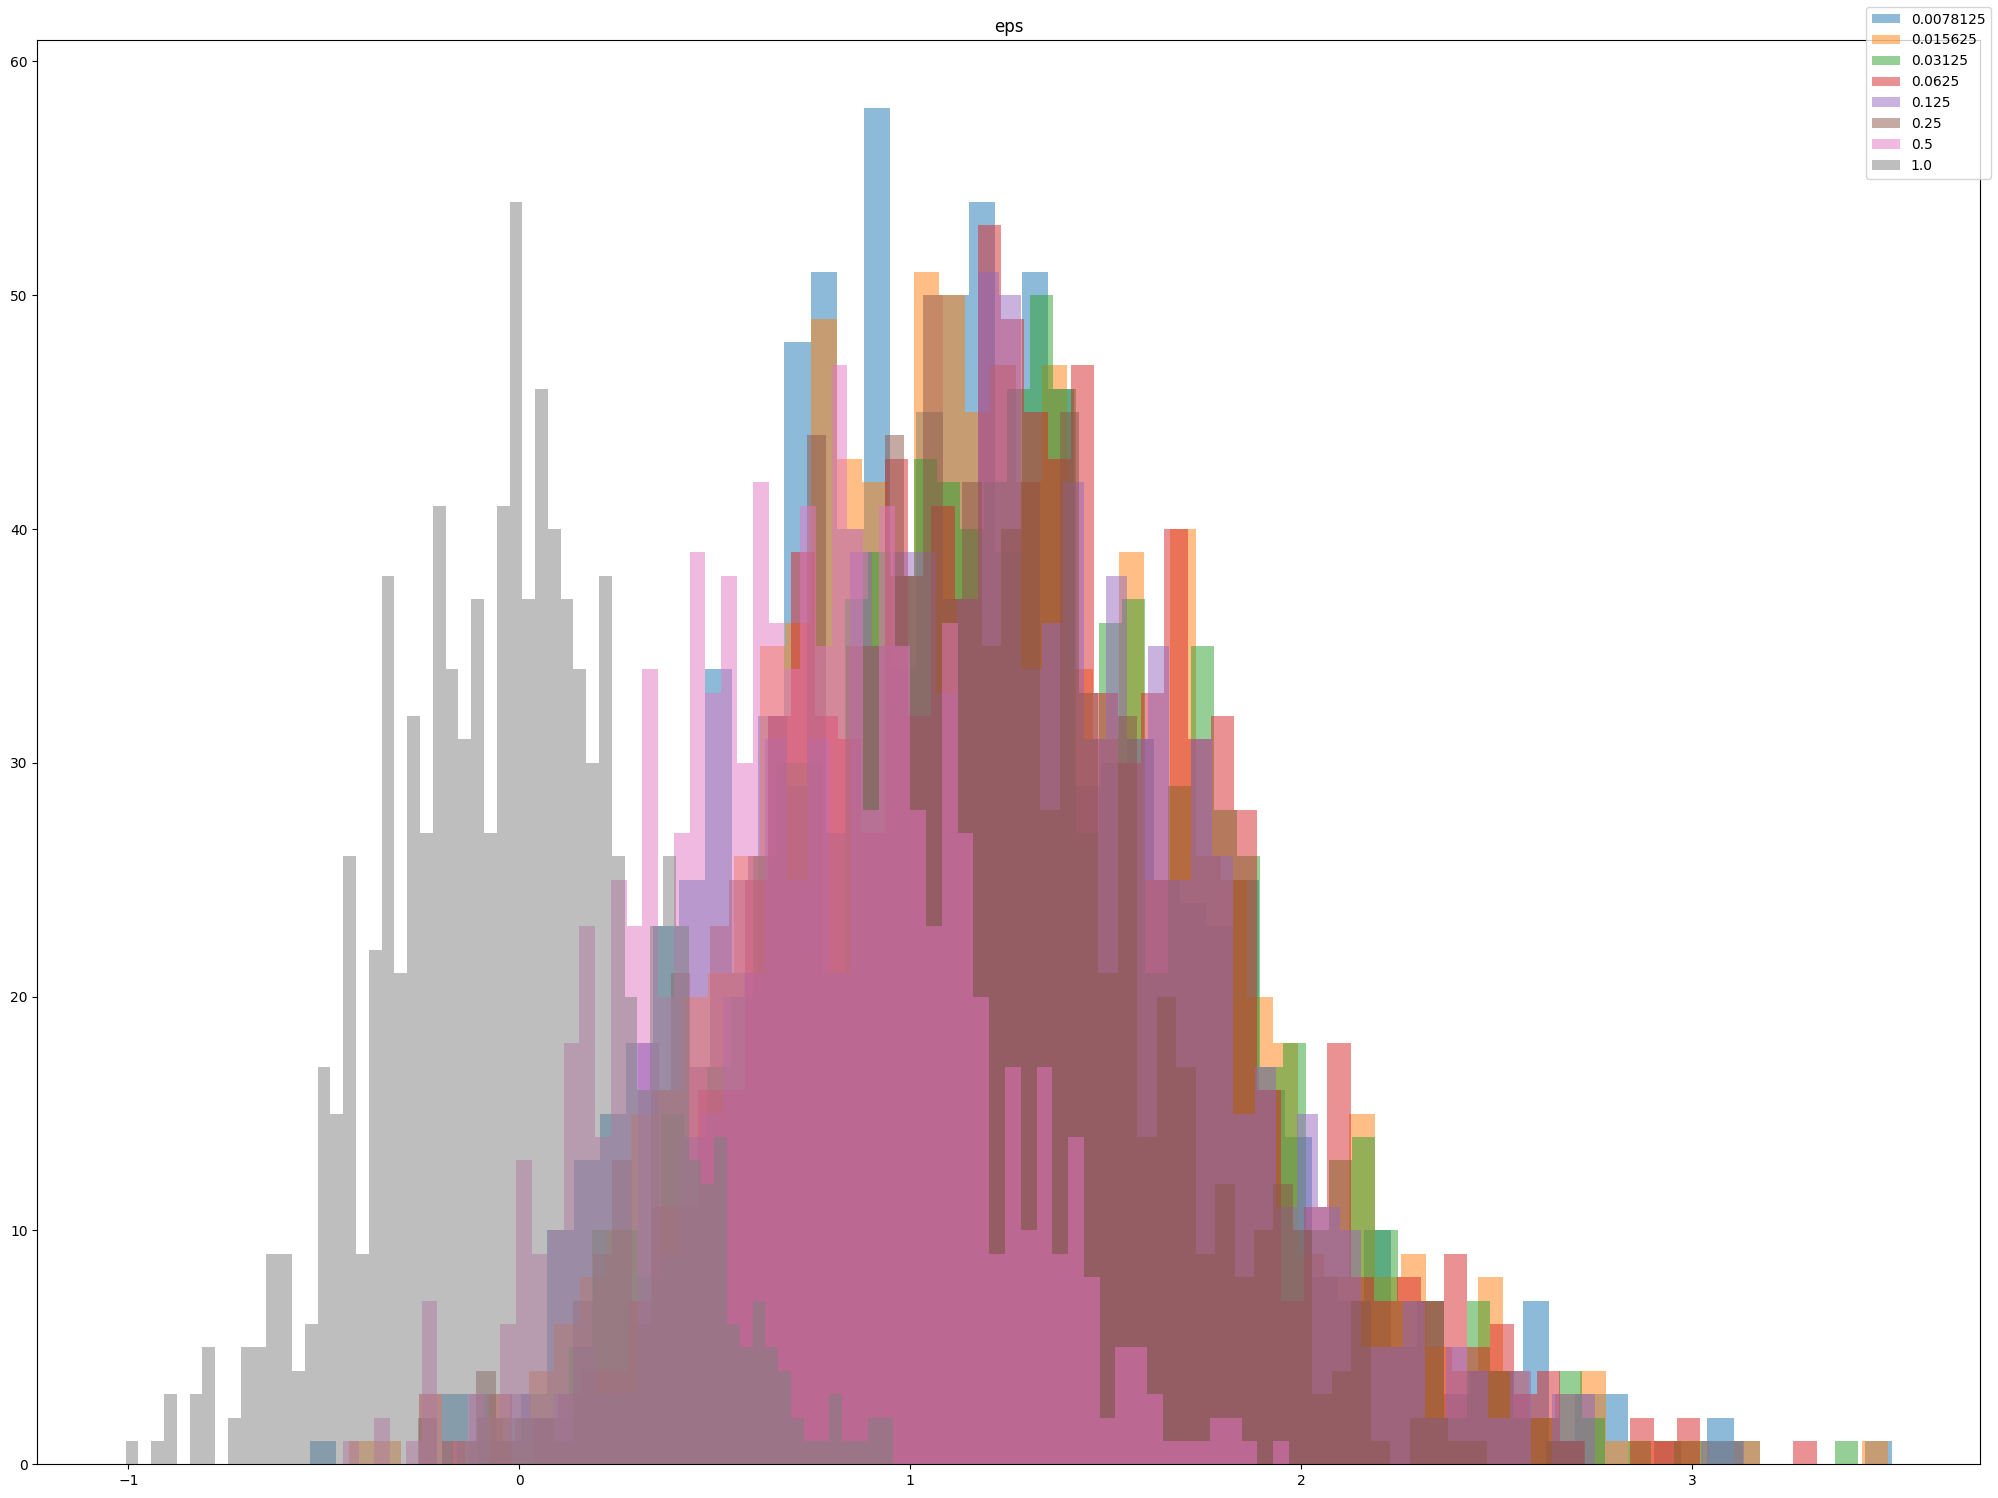

epsOpt 0.0078125 [-0.29868841  0.90680785  1.25455552  1.61609335  3.19382995]
epsOpt 0.015625 [-0.26166899  0.89626652  1.25377551  1.62063532  3.18185644]
epsOpt 0.03125 [-0.35524651  0.88669378  1.24223331  1.59961344  3.22012482]
epsOpt 0.0625 [-0.08425309  0.90078535  1.25031848  1.60505366  3.24174478]
epsOpt 0.125 [-0.17855299  0.89861892  1.25014712  1.61822335  3.20574899]
epsOpt 0.25 [-0.31474695  0.90609708  1.26064437  1.61034856  3.23657388]
epsOpt 0.5 [-0.26057111  0.91141004  1.26311938  1.64168424  3.19290407]
epsOpt 1.0 [-0.33934331  0.90608414  1.25882264  1.64040689  3.19666484]
epsOpt 2.0 [-0.17872831  0.91034331  1.26679684  1.63809066  3.23701372]
epsOpt 4.0 [-0.19492052  0.90567408  1.27068744  1.64455274  3.25055397]


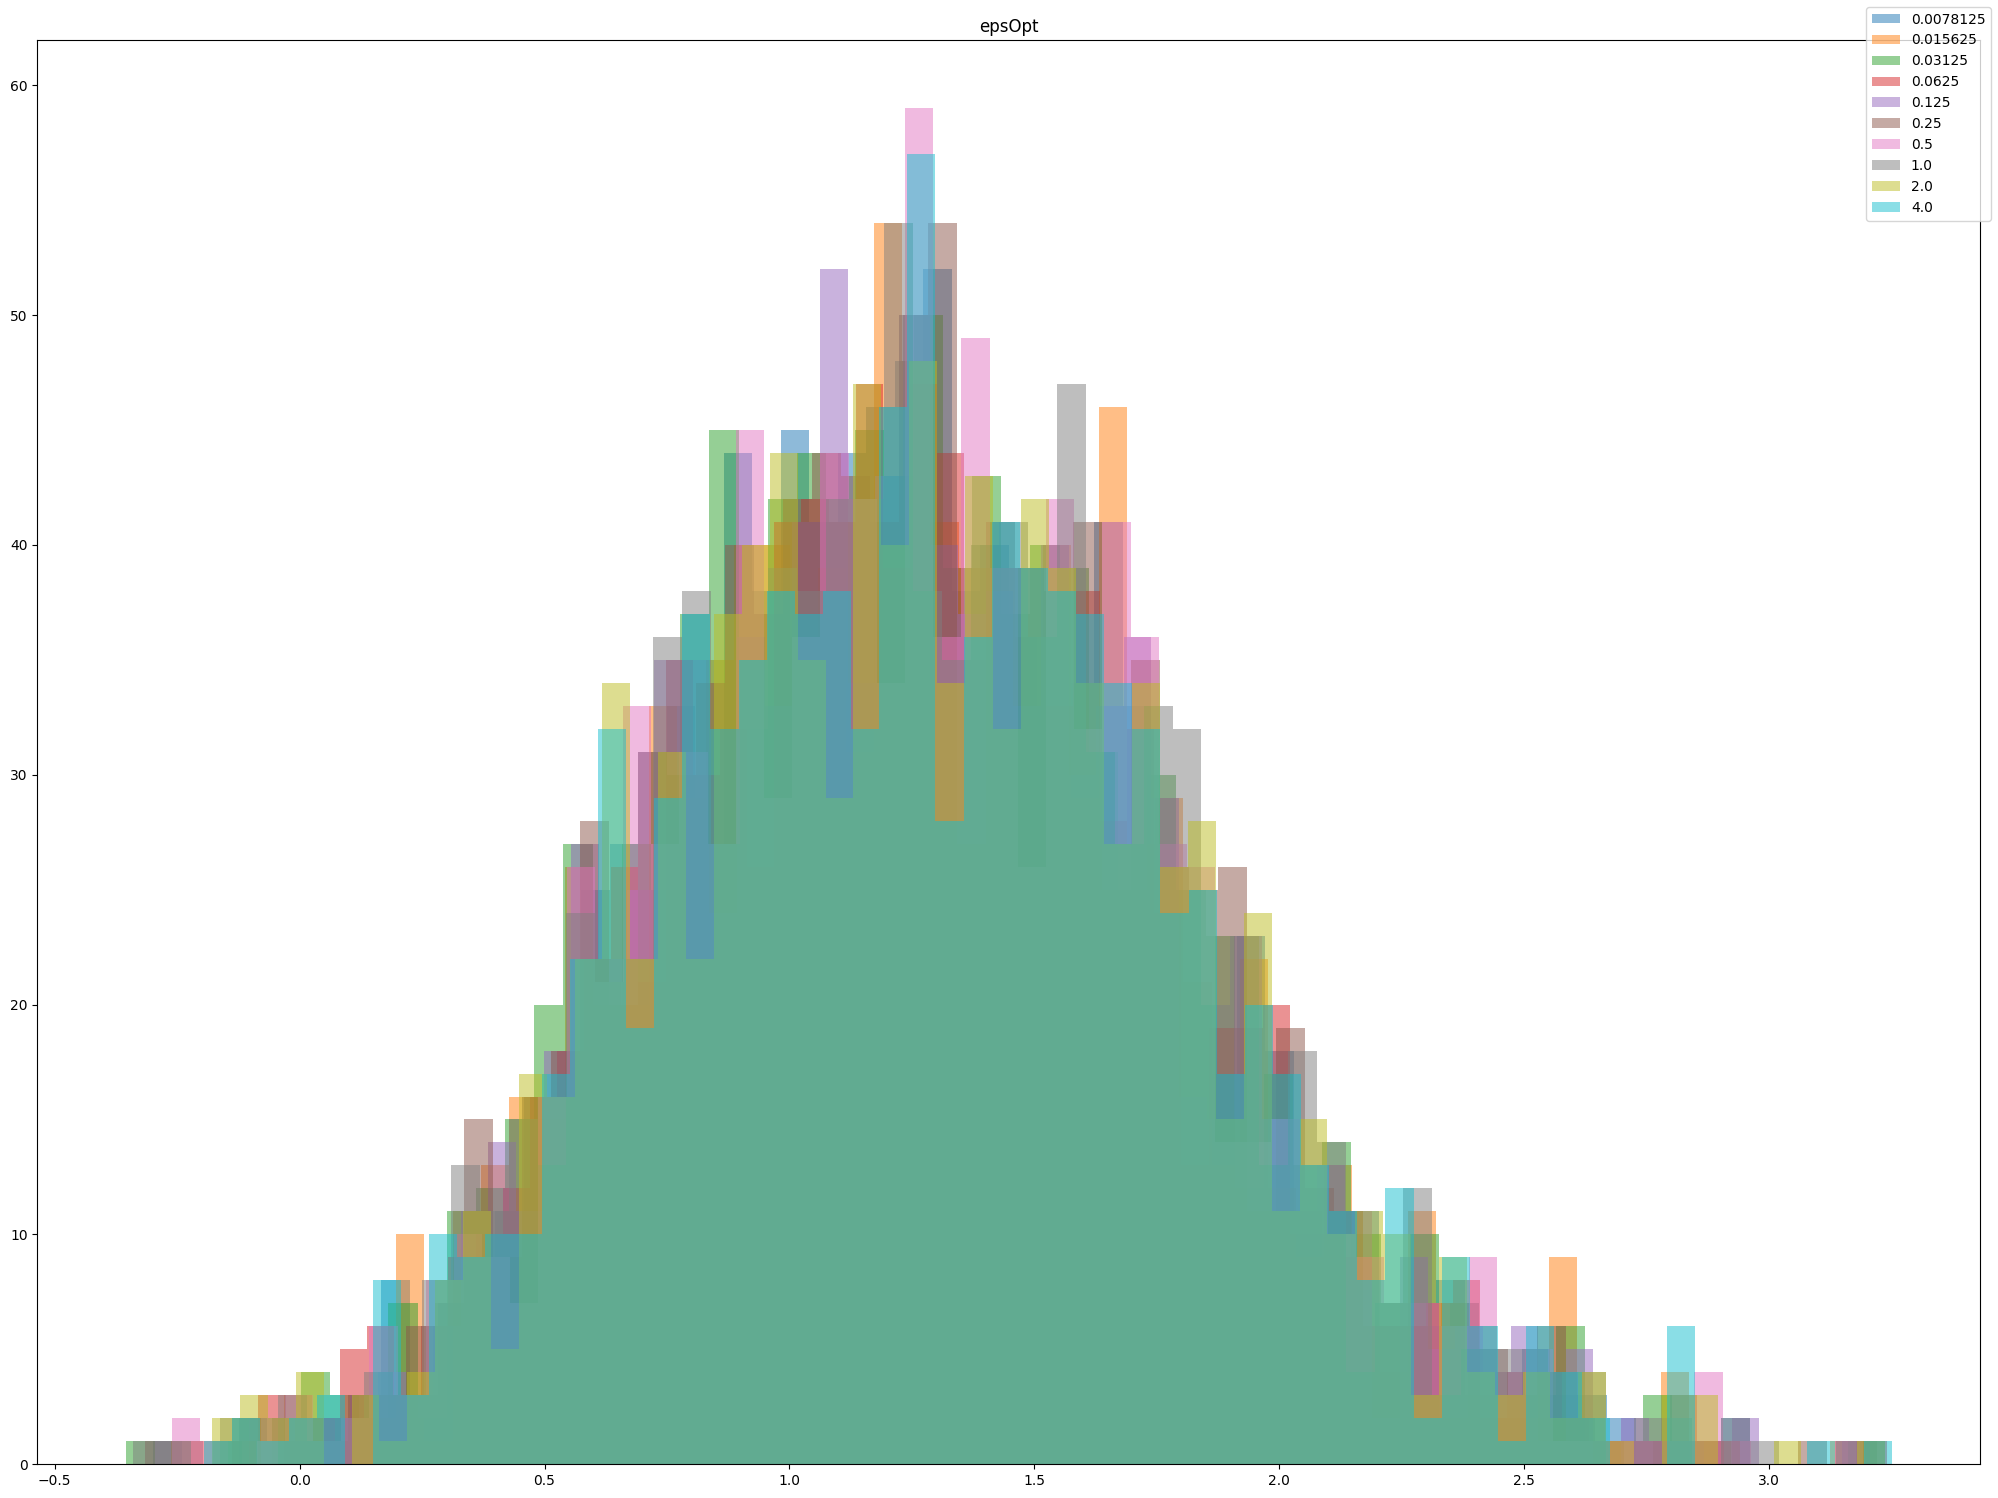

gradient 0.0078125 [-0.79696282  0.11373784  0.38727515  0.63817532  1.96318685]
gradient 0.015625 [-0.55374889  0.39023566  0.72343233  1.08867417  2.43204269]
gradient 0.03125 [-0.34179821  0.67473522  1.02688836  1.41043994  3.22401919]
gradient 0.0625 [-0.20090507  0.83721495  1.21866339  1.60130368  3.16205992]
gradient 0.125 [-0.09785124  0.92985751  1.30433457  1.68904728  3.35536542]
gradient 0.25 [-0.33489108  0.94031628  1.30908255  1.72288867  3.48585711]
gradient 0.5 [-0.17629208  0.89675525  1.29408205  1.68548379  3.31825723]
gradient 1.0 [-0.31804885  0.80433287  1.19078642  1.592575    3.43021113]
gradient 2.0 [-1.00576694  0.62529963  1.024656    1.48944316  3.51996233]
gradient 4.0 [-1.41208045  0.469156    0.88734466  1.34318101  3.19152823]


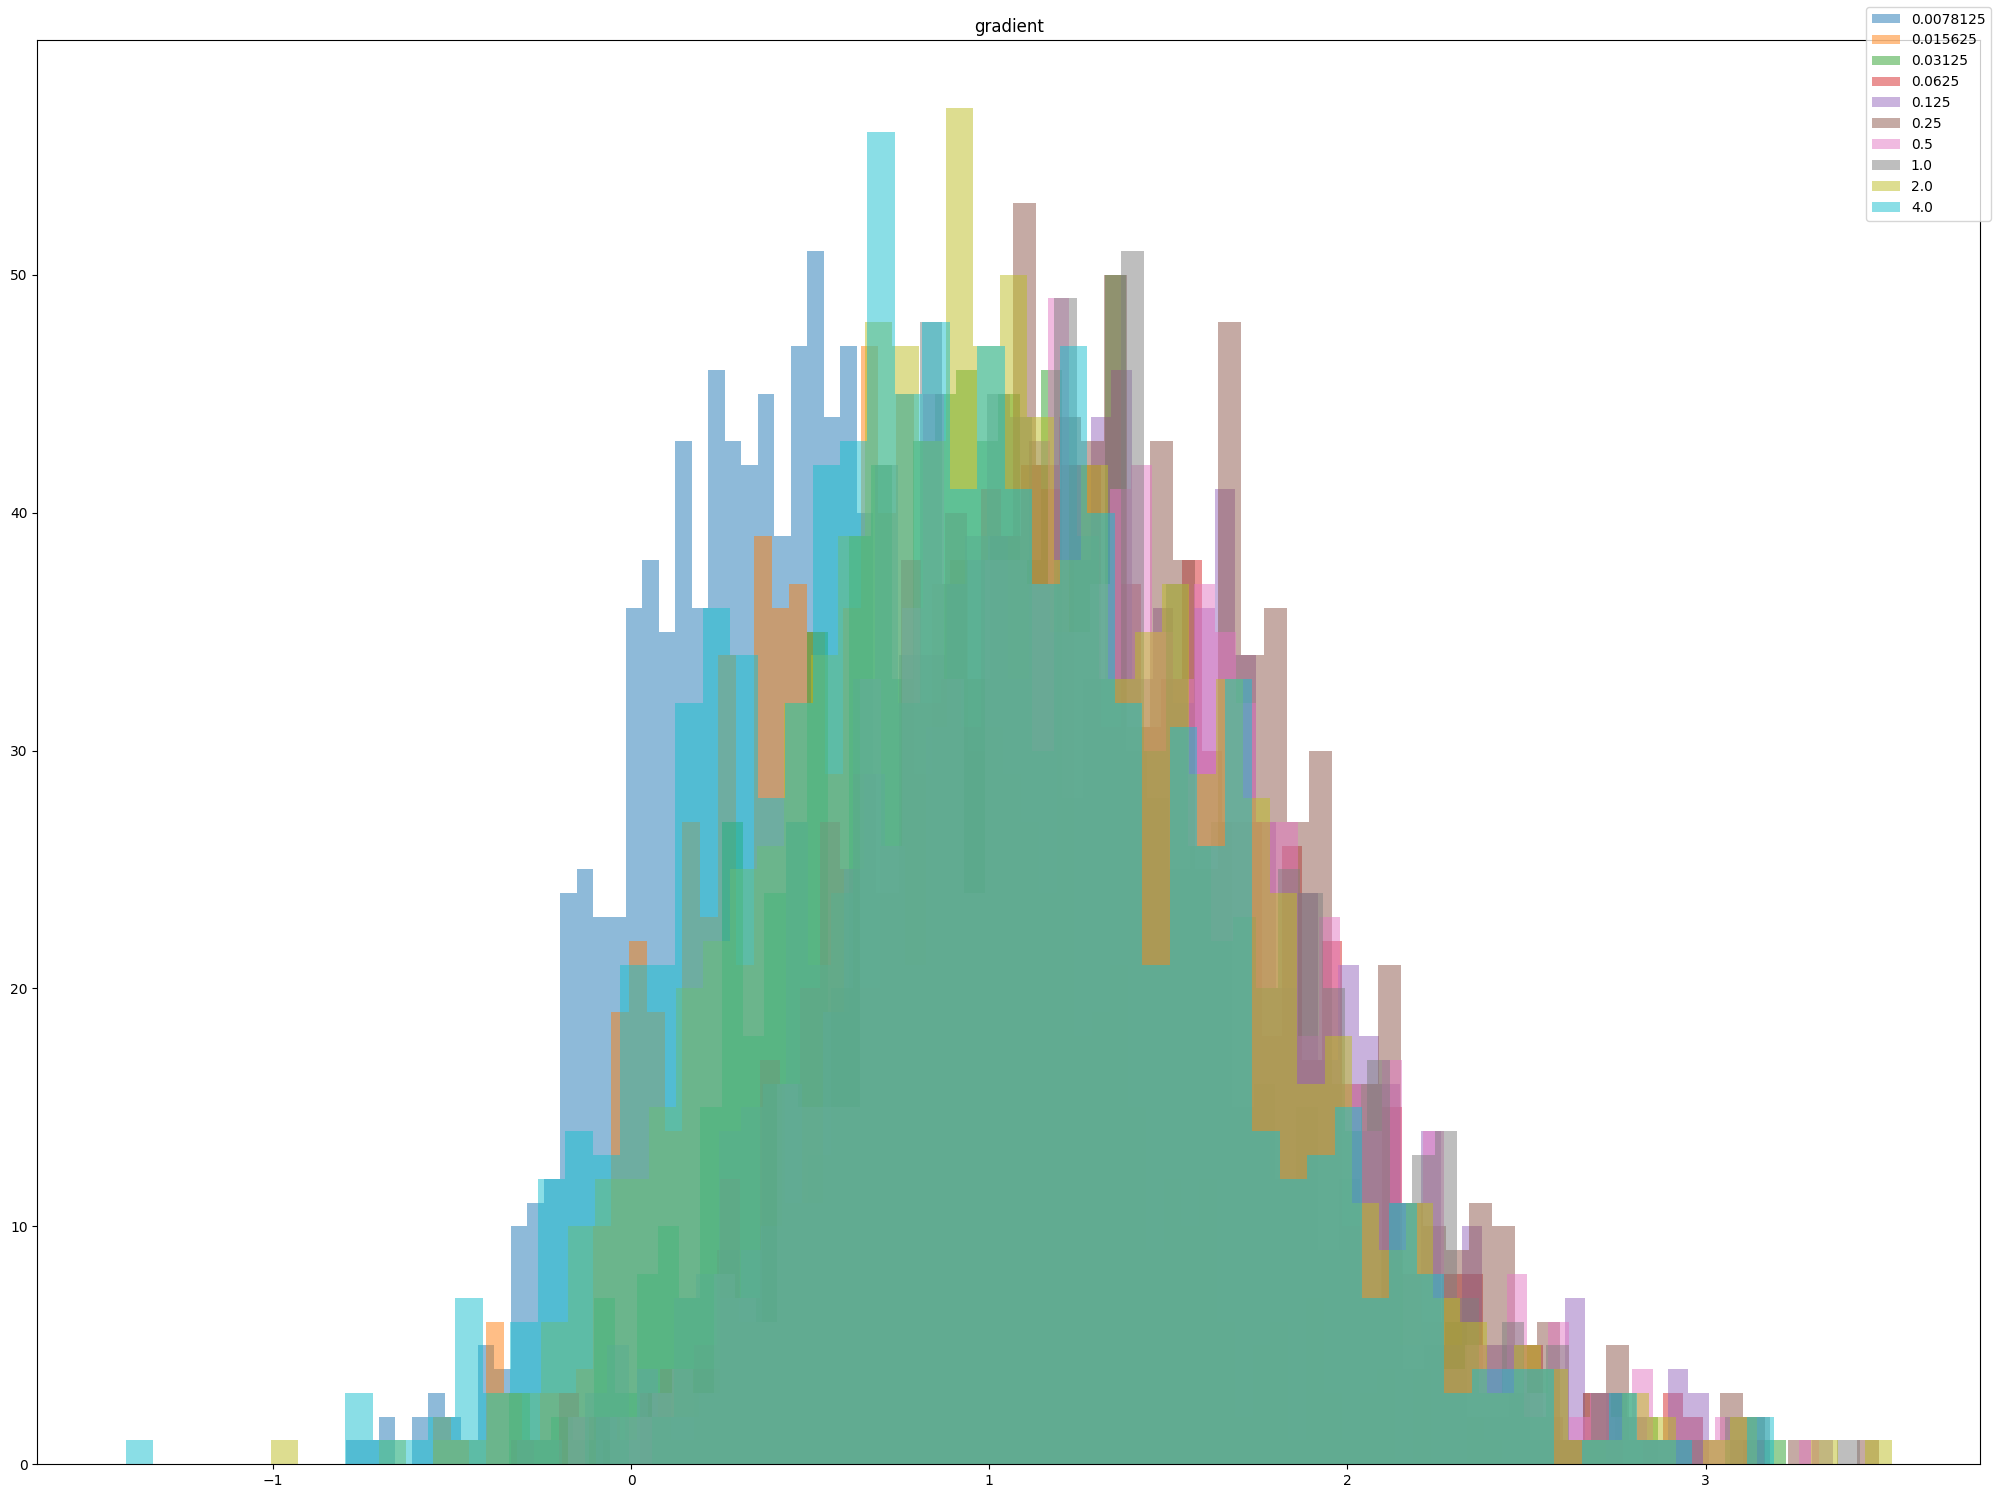

ucb 0.0078125 [-0.31960768  0.94282081  1.33364698  1.77640777  3.51590534]
ucb 0.015625 [-0.27645019  0.9298462   1.32850971  1.77640777  3.51590534]
ucb 0.03125 [-0.31363934  0.94359197  1.33364698  1.77760815  3.51590534]
ucb 0.0625 [-0.32879538  0.93953536  1.33886048  1.77760815  3.51590534]
ucb 0.125 [-0.31475214  0.95609538  1.36573833  1.78314984  3.51590534]
ucb 0.25 [-0.13658642  0.99428798  1.37131807  1.79193416  3.51590534]
ucb 0.5 [-0.24957185  1.02287498  1.39587875  1.81217747  3.51470941]
ucb 1.0 [-0.07520661  1.03292435  1.39780194  1.80717382  3.50137917]
ucb 2.0 [-0.22175332  0.9309691   1.30873478  1.72425914  3.45125593]
ucb 4.0 [-0.37313982  0.71316076  1.08540708  1.48787673  3.26839627]


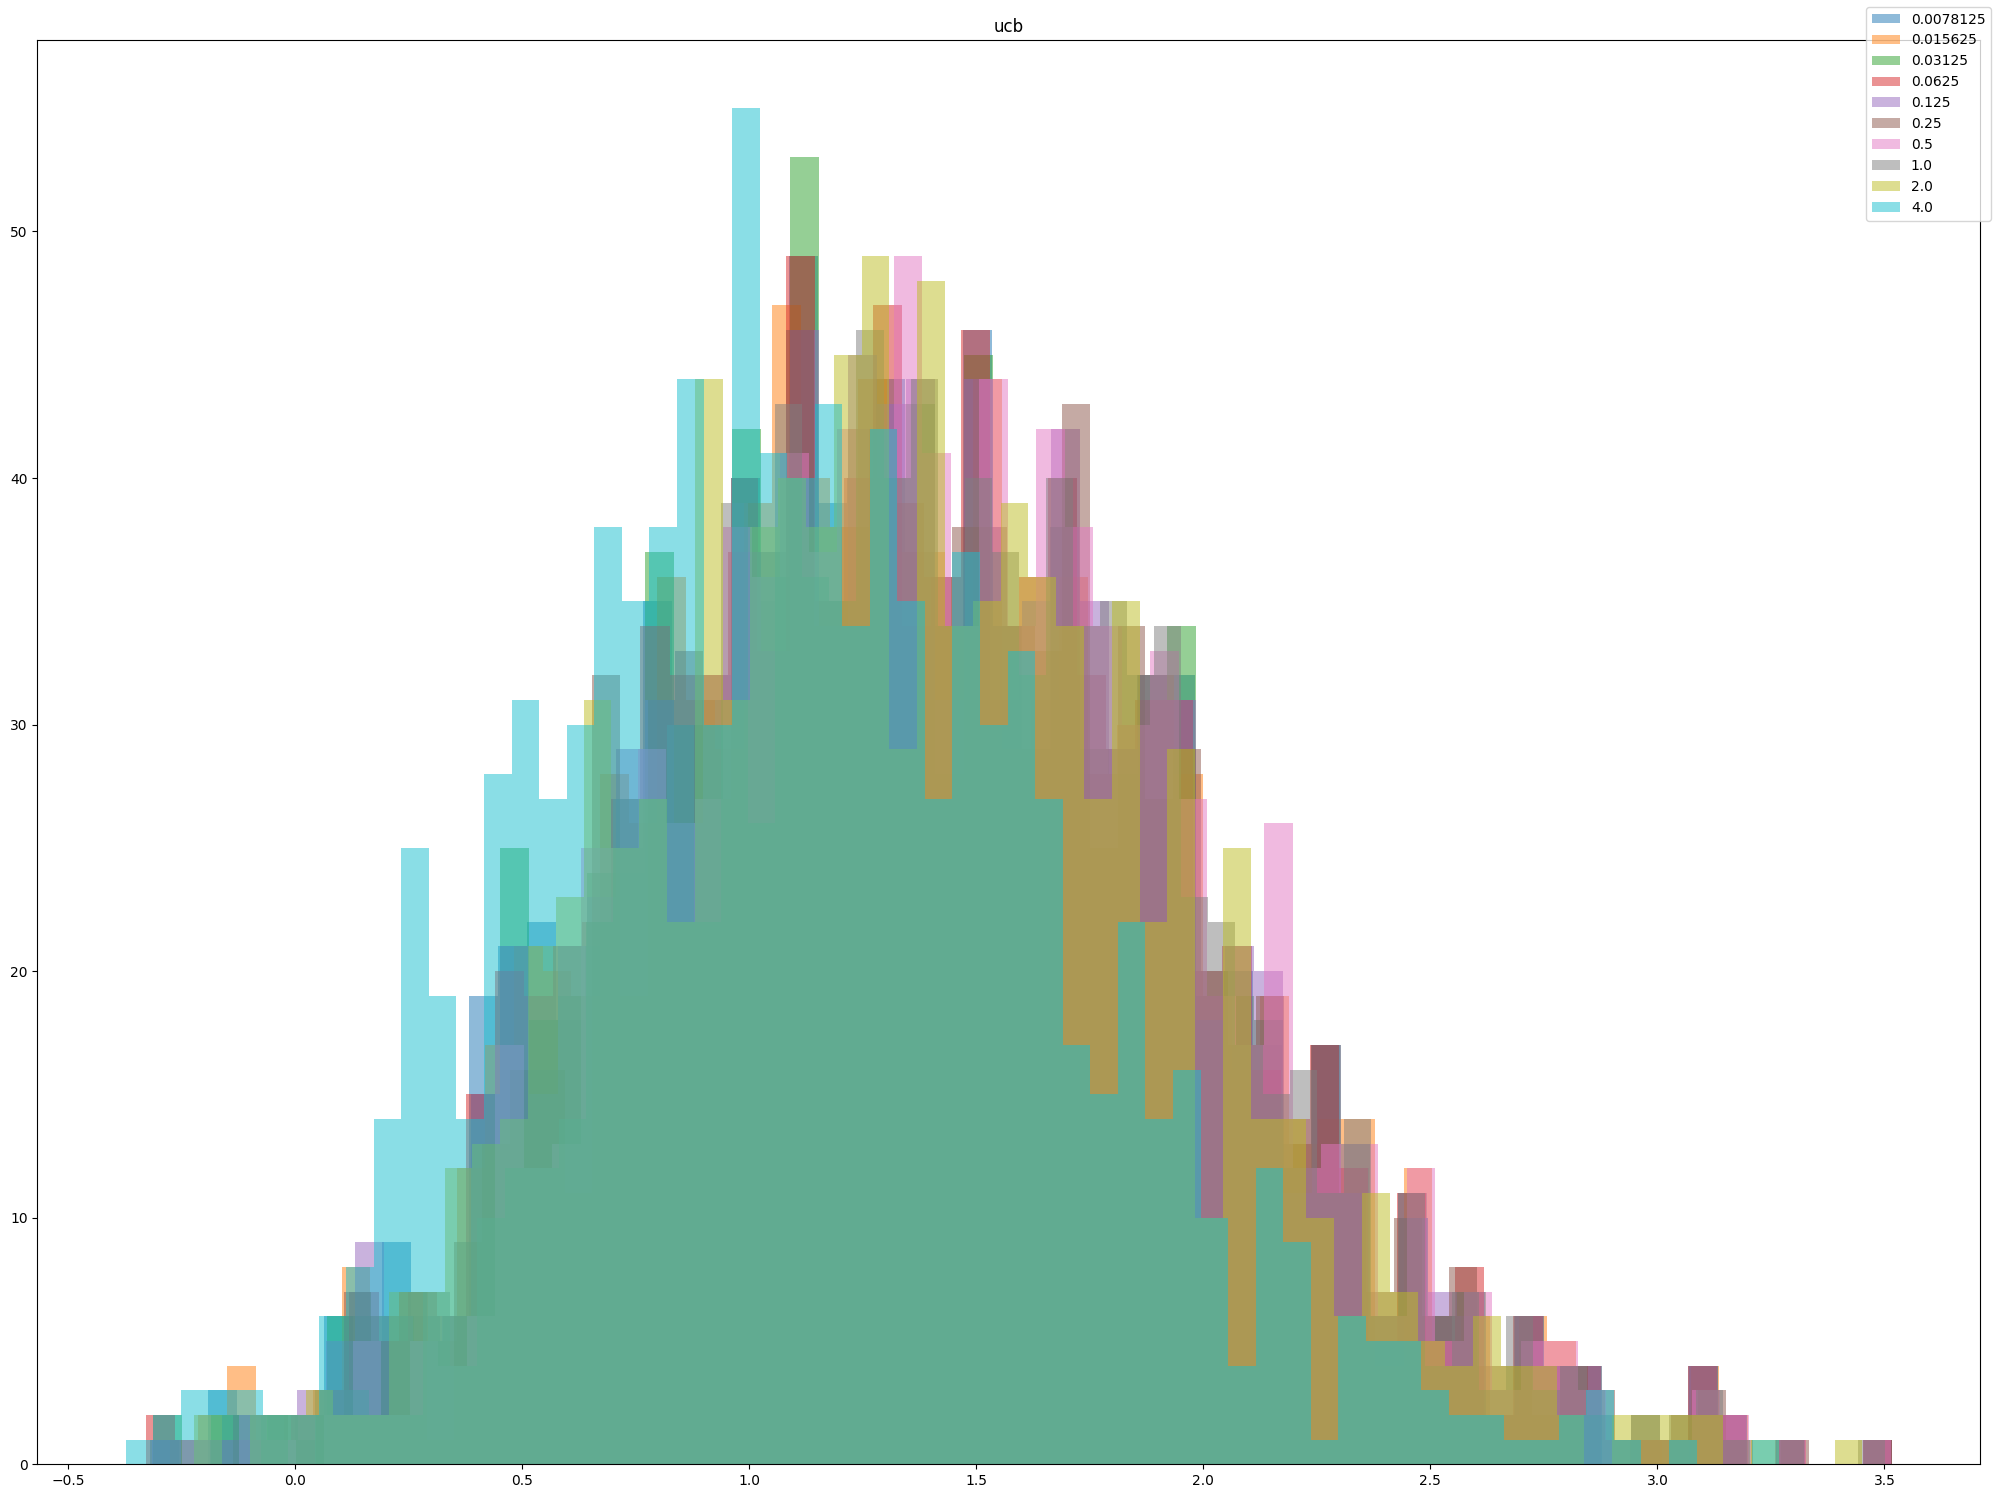

In [11]:
cols = meanRewardsExp[0].columns
params = meanRewardsExp[0].index.values
hists = {}
import itertools
for i, choices in enumerate( meanRewardsExp ):
    for param, col in itertools.product(params, cols):
        if col not in hists.keys():
            hists[col] = {}
        colHist = hists[col]
        if param not in colHist.keys():
            colHist[param] = np.zeros( n_trials )
        hists[col][param][i] = choices.loc[param, col]

for col in cols:
    fig, ax = plt.subplots()
    results = hists[col]
    for param, res in results.items():
        if not np.isnan( res ).any():
            ax.hist( res, bins = int( np.sqrt( n_trials ) / 2 ) * 4, label = param, alpha = .5 )
            print( col, param, np.quantile( res, [i * .25 for i in range( 0, 5 )]))
    ax.set_title( col )
    fig.legend()
    fig.tight_layout()
    plt.show()

eps 0.0078125 [0.         0.         0.48148148 0.98498498 0.997998  ]
eps 0.015625 [0.         0.00375375 0.71771772 0.97622623 0.99299299]
eps 0.03125 [0.         0.22297297 0.81531532 0.96096096 0.98398398]
eps 0.0625 [0.         0.51426426 0.85635636 0.93093093 0.95895896]
eps 0.125 [0.00700701 0.67667668 0.83883884 0.87412412 0.91191191]
eps 0.25 [0.01201201 0.68168168 0.74174174 0.76576577 0.81681682]
eps 0.5 [0.03503504 0.49349349 0.52852853 0.54554555 0.59059059]
eps 1.0 [0.07007007 0.09409409 0.1001001  0.10610611 0.13013013]
eps 2.0 [0.        0.        0.        0.        0.5005005]
eps 4.0 [0.        0.        0.        0.        0.5005005]


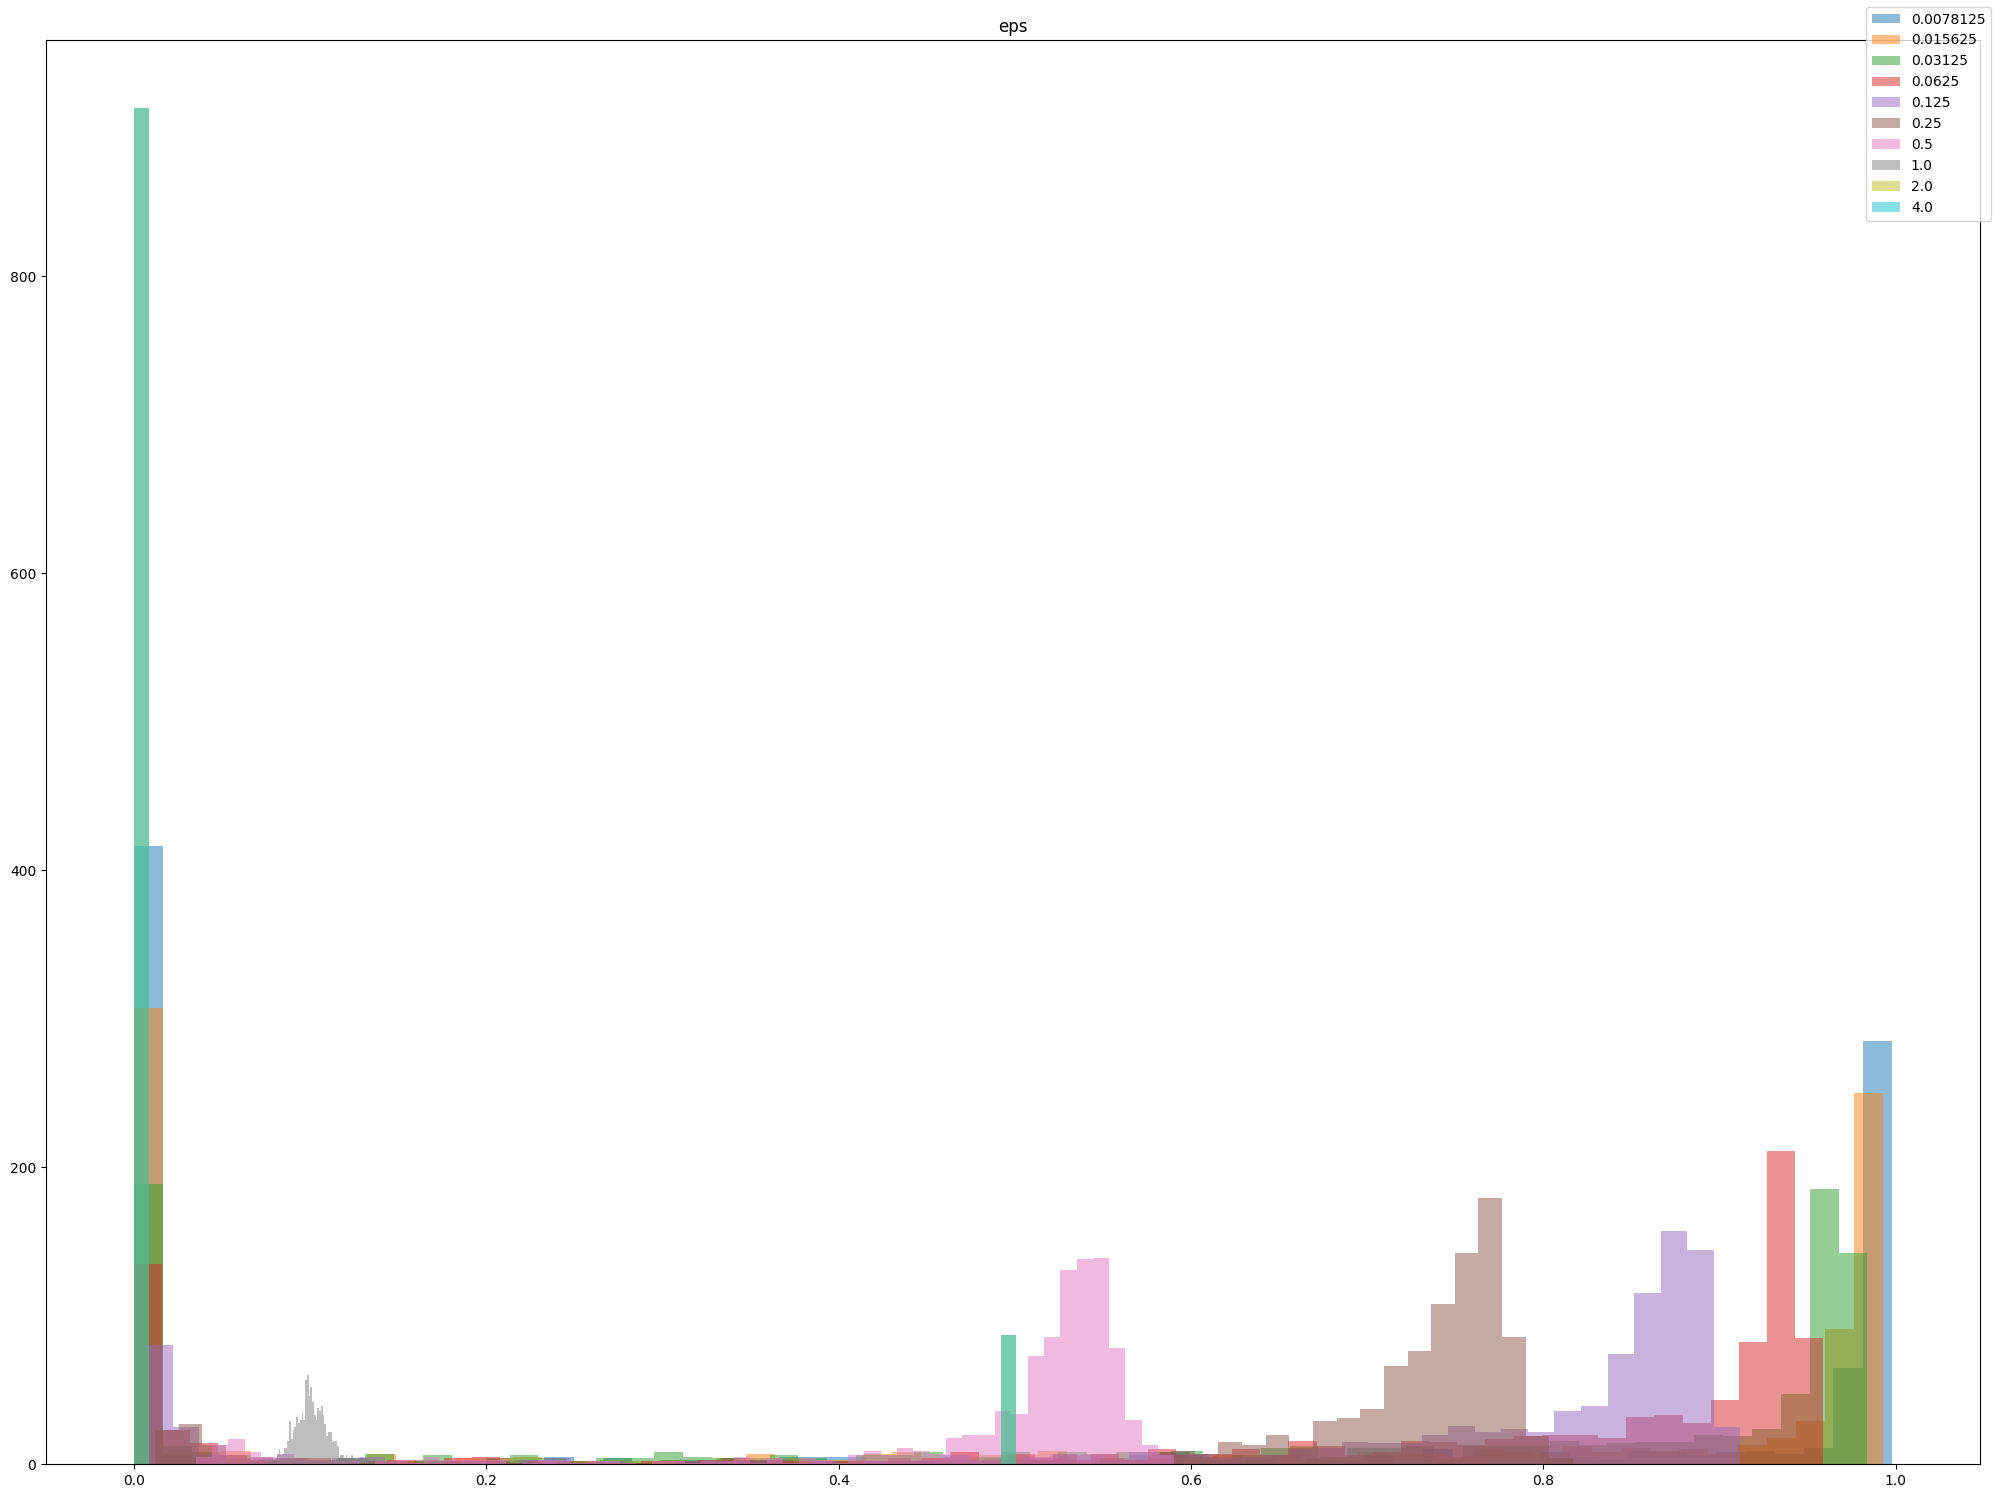

epsOpt 0.0078125 [0.003003   0.66391391 0.85235235 0.8968969  0.93093093]
epsOpt 0.015625 [0.004004   0.66841842 0.85385385 0.8978979  0.93593594]
epsOpt 0.03125 [0.002002   0.61836837 0.85085085 0.8978979  0.92992993]
epsOpt 0.0625 [0.003003   0.66341341 0.85785786 0.8988989  0.93093093]
epsOpt 0.125 [0.         0.67367367 0.86186186 0.89914915 0.94094094]
epsOpt 0.25 [0.002002   0.65415415 0.86886887 0.8998999  0.93193193]
epsOpt 0.5 [0.002002   0.73398398 0.88088088 0.9019019  0.93593594]
epsOpt 1.0 [0.00500501 0.72622623 0.88488488 0.9019019  0.92892893]
epsOpt 2.0 [0.004004   0.75475475 0.88988989 0.9009009  0.93293293]
epsOpt 4.0 [0.00500501 0.77727728 0.88738739 0.8998999  0.92692693]


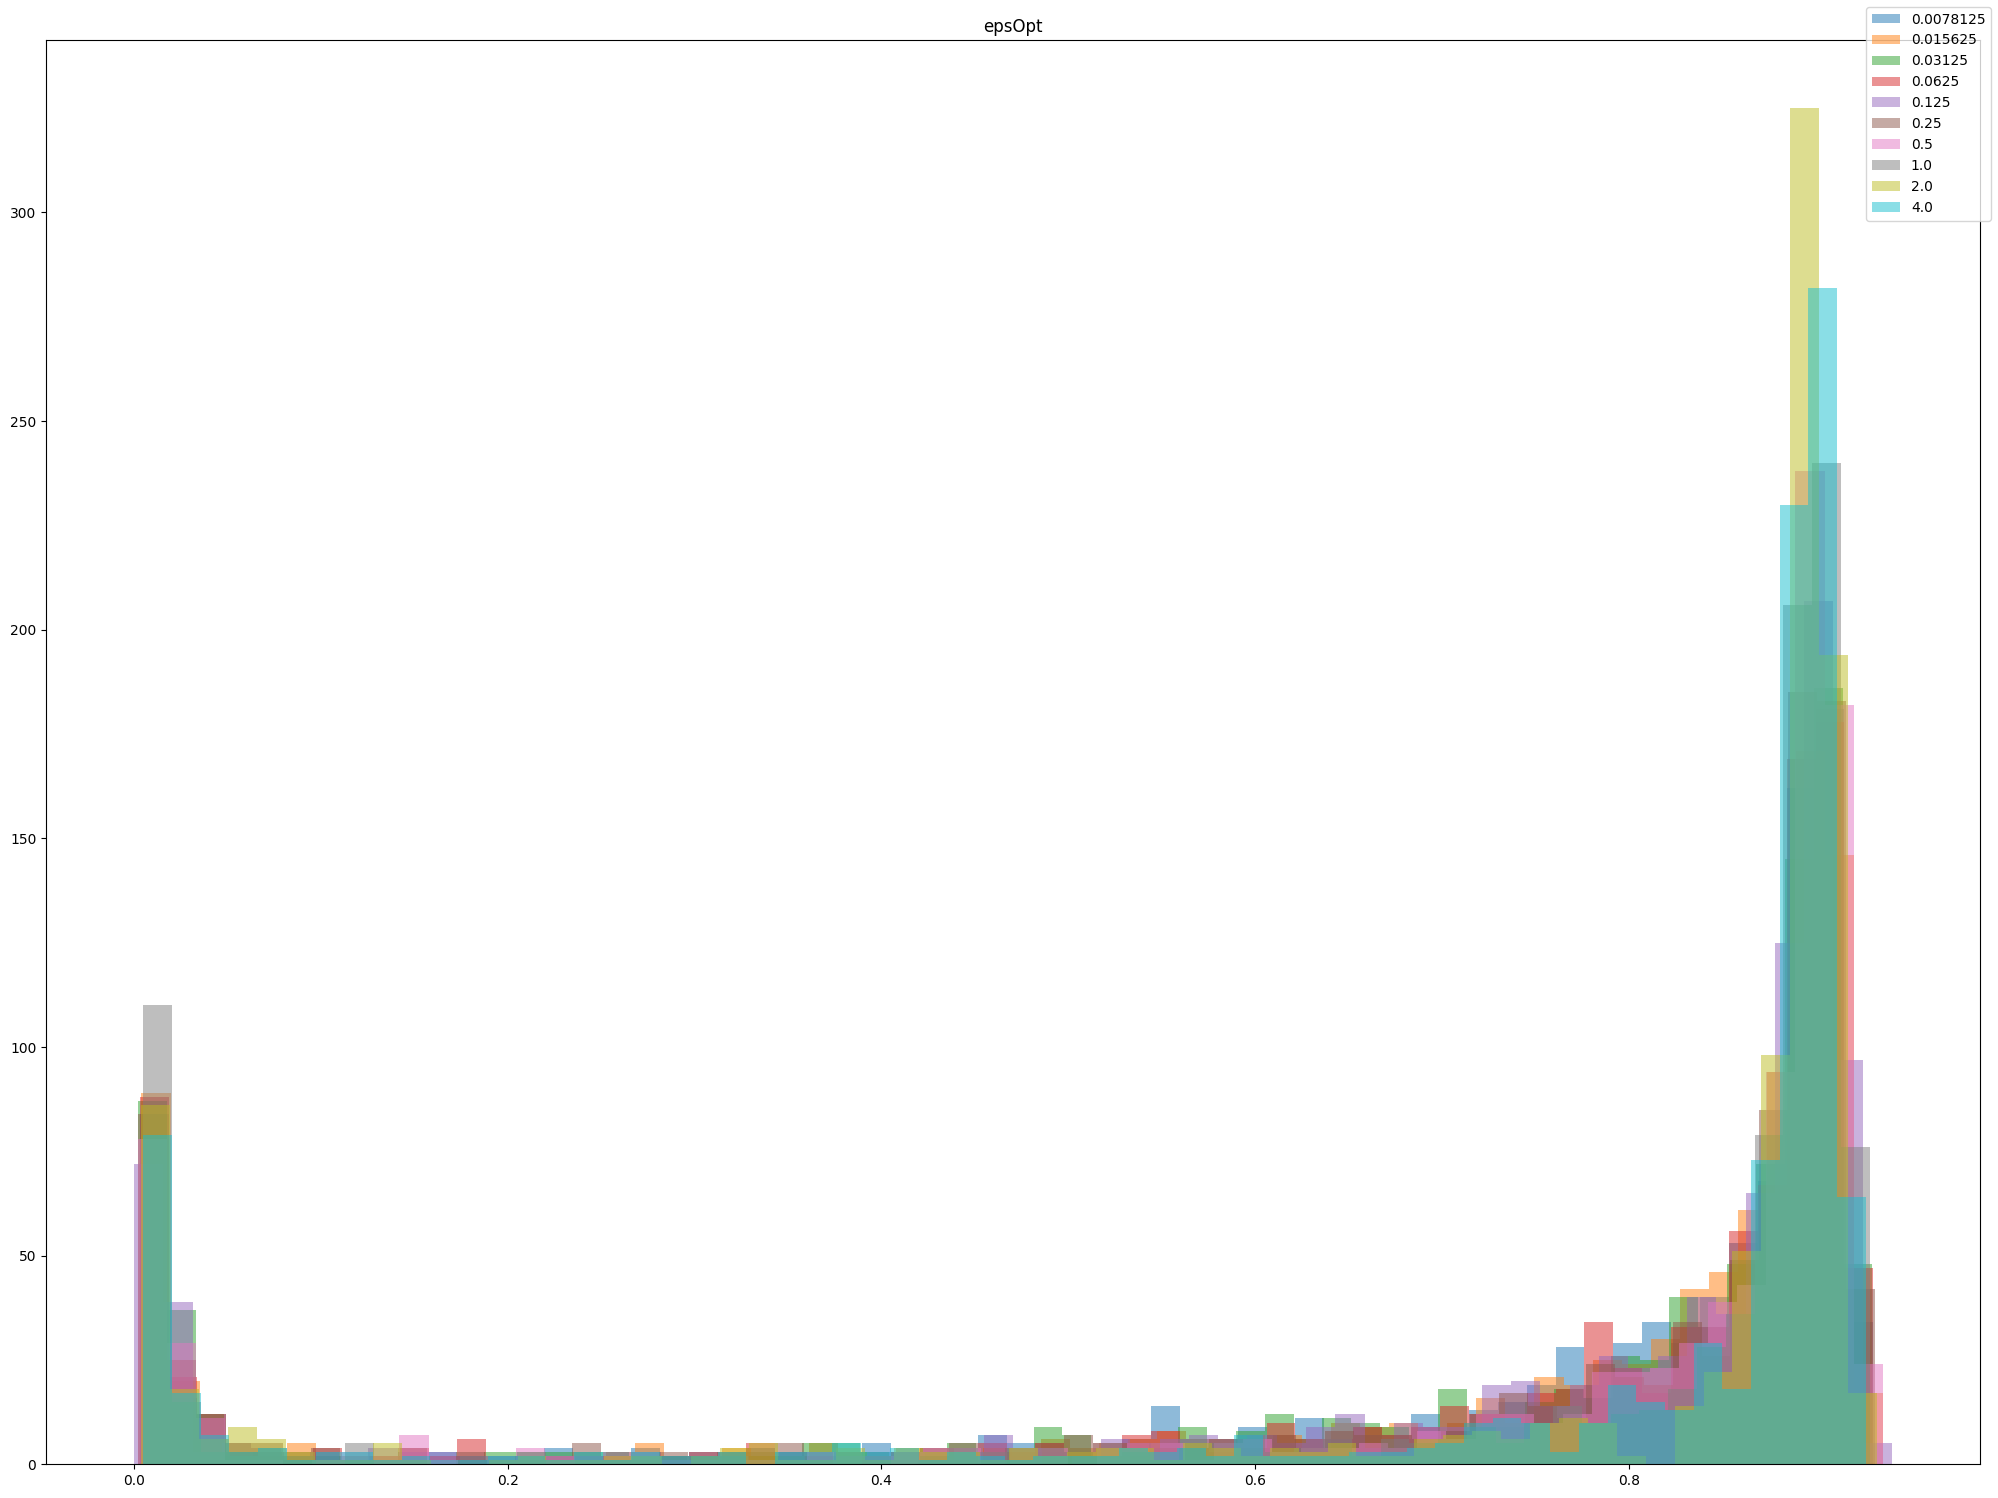

gradient 0.0078125 [0.0960961  0.16016016 0.2002002  0.26951952 0.57757758]
gradient 0.015625 [0.05605606 0.25925926 0.4019019  0.53853854 0.8048048 ]
gradient 0.03125 [0.01701702 0.47547548 0.65065065 0.75075075 0.9029029 ]
gradient 0.0625 [0.00600601 0.69044044 0.8028028  0.86786787 0.95395395]
gradient 0.125 [0.001001   0.7545045  0.89189189 0.92892893 0.98098098]
gradient 0.25 [0.         0.1463964  0.93793794 0.96496496 0.99299299]
gradient 0.5 [0.         0.00500501 0.95795796 0.98098098 0.996997  ]
gradient 1.0 [0.         0.001001   0.91441441 0.98998999 1.        ]
gradient 2.0 [0.         0.         0.001001   0.99199199 1.        ]
gradient 4.0 [0.         0.         0.         0.99324324 1.        ]


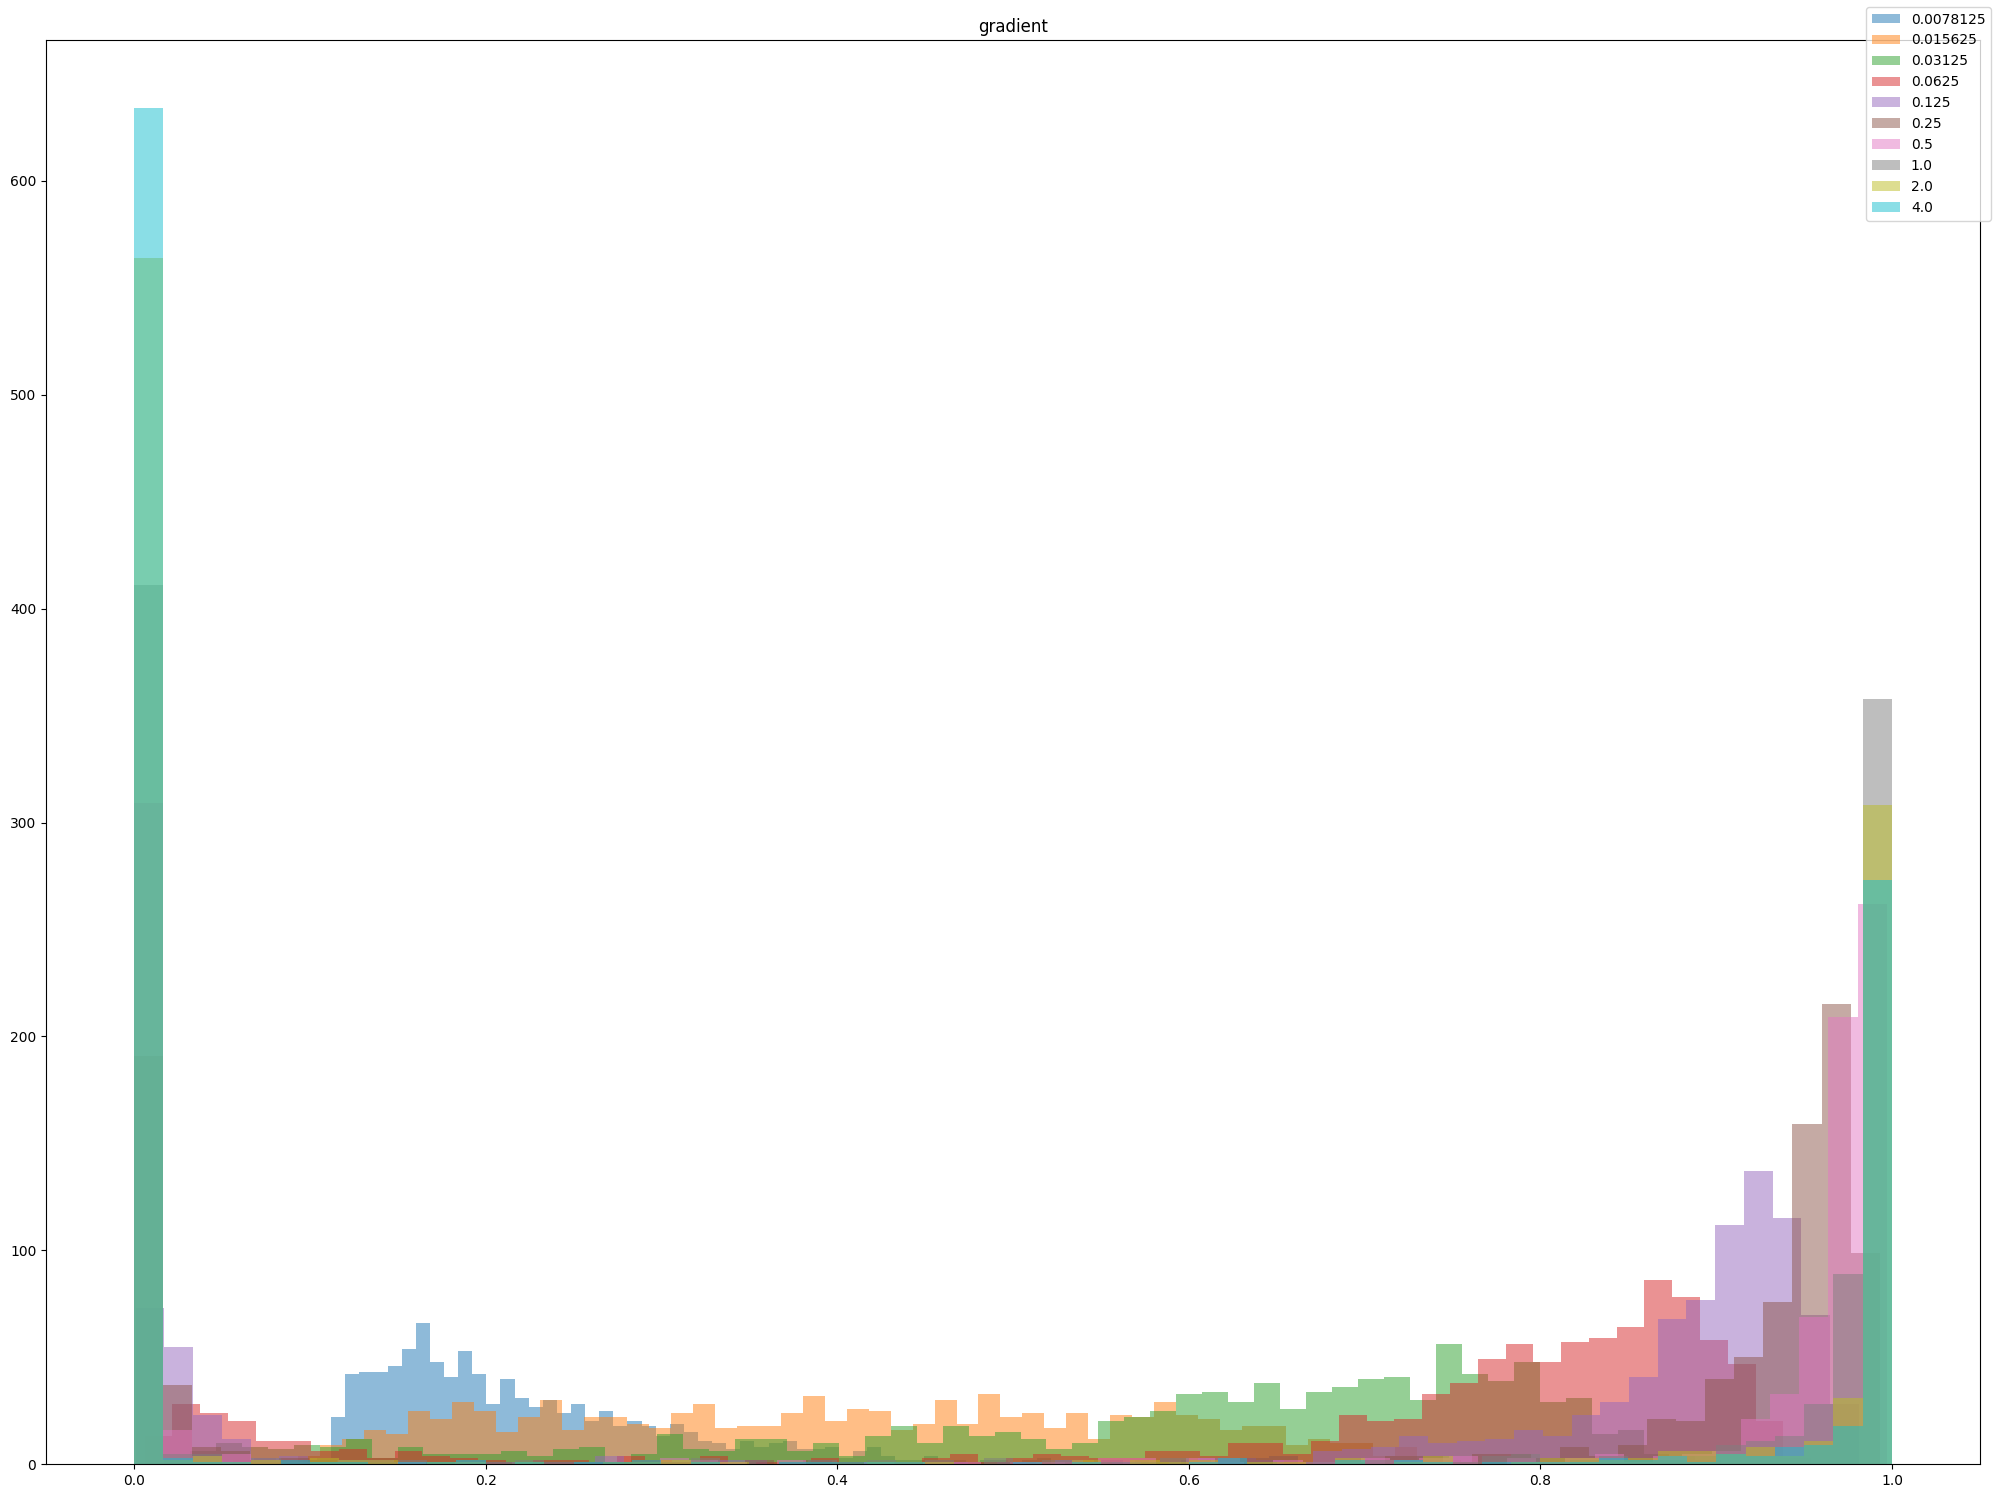

ucb 0.0078125 [0.         0.003003   0.98698699 0.99099099 0.99199199]
ucb 0.015625 [0.         0.003003   0.98698699 0.99099099 0.99199199]
ucb 0.03125 [0.         0.003003   0.98648649 0.99099099 0.99199199]
ucb 0.0625 [0.         0.004004   0.98598599 0.98998999 0.99199199]
ucb 0.125 [0.         0.00875876 0.98498498 0.98998999 0.99199199]
ucb 0.25 [0.         0.86786787 0.98298298 0.98898899 0.99199199]
ucb 0.5 [0.         0.8983984  0.97297297 0.98498498 0.99199199]
ucb 1.0 [0.001001   0.83258258 0.93793794 0.96796797 0.99099099]
ucb 2.0 [0.0970971  0.63338338 0.80730731 0.8988989  0.97897898]
ucb 4.0 [0.10710711 0.40790791 0.55455455 0.70695696 0.91491491]


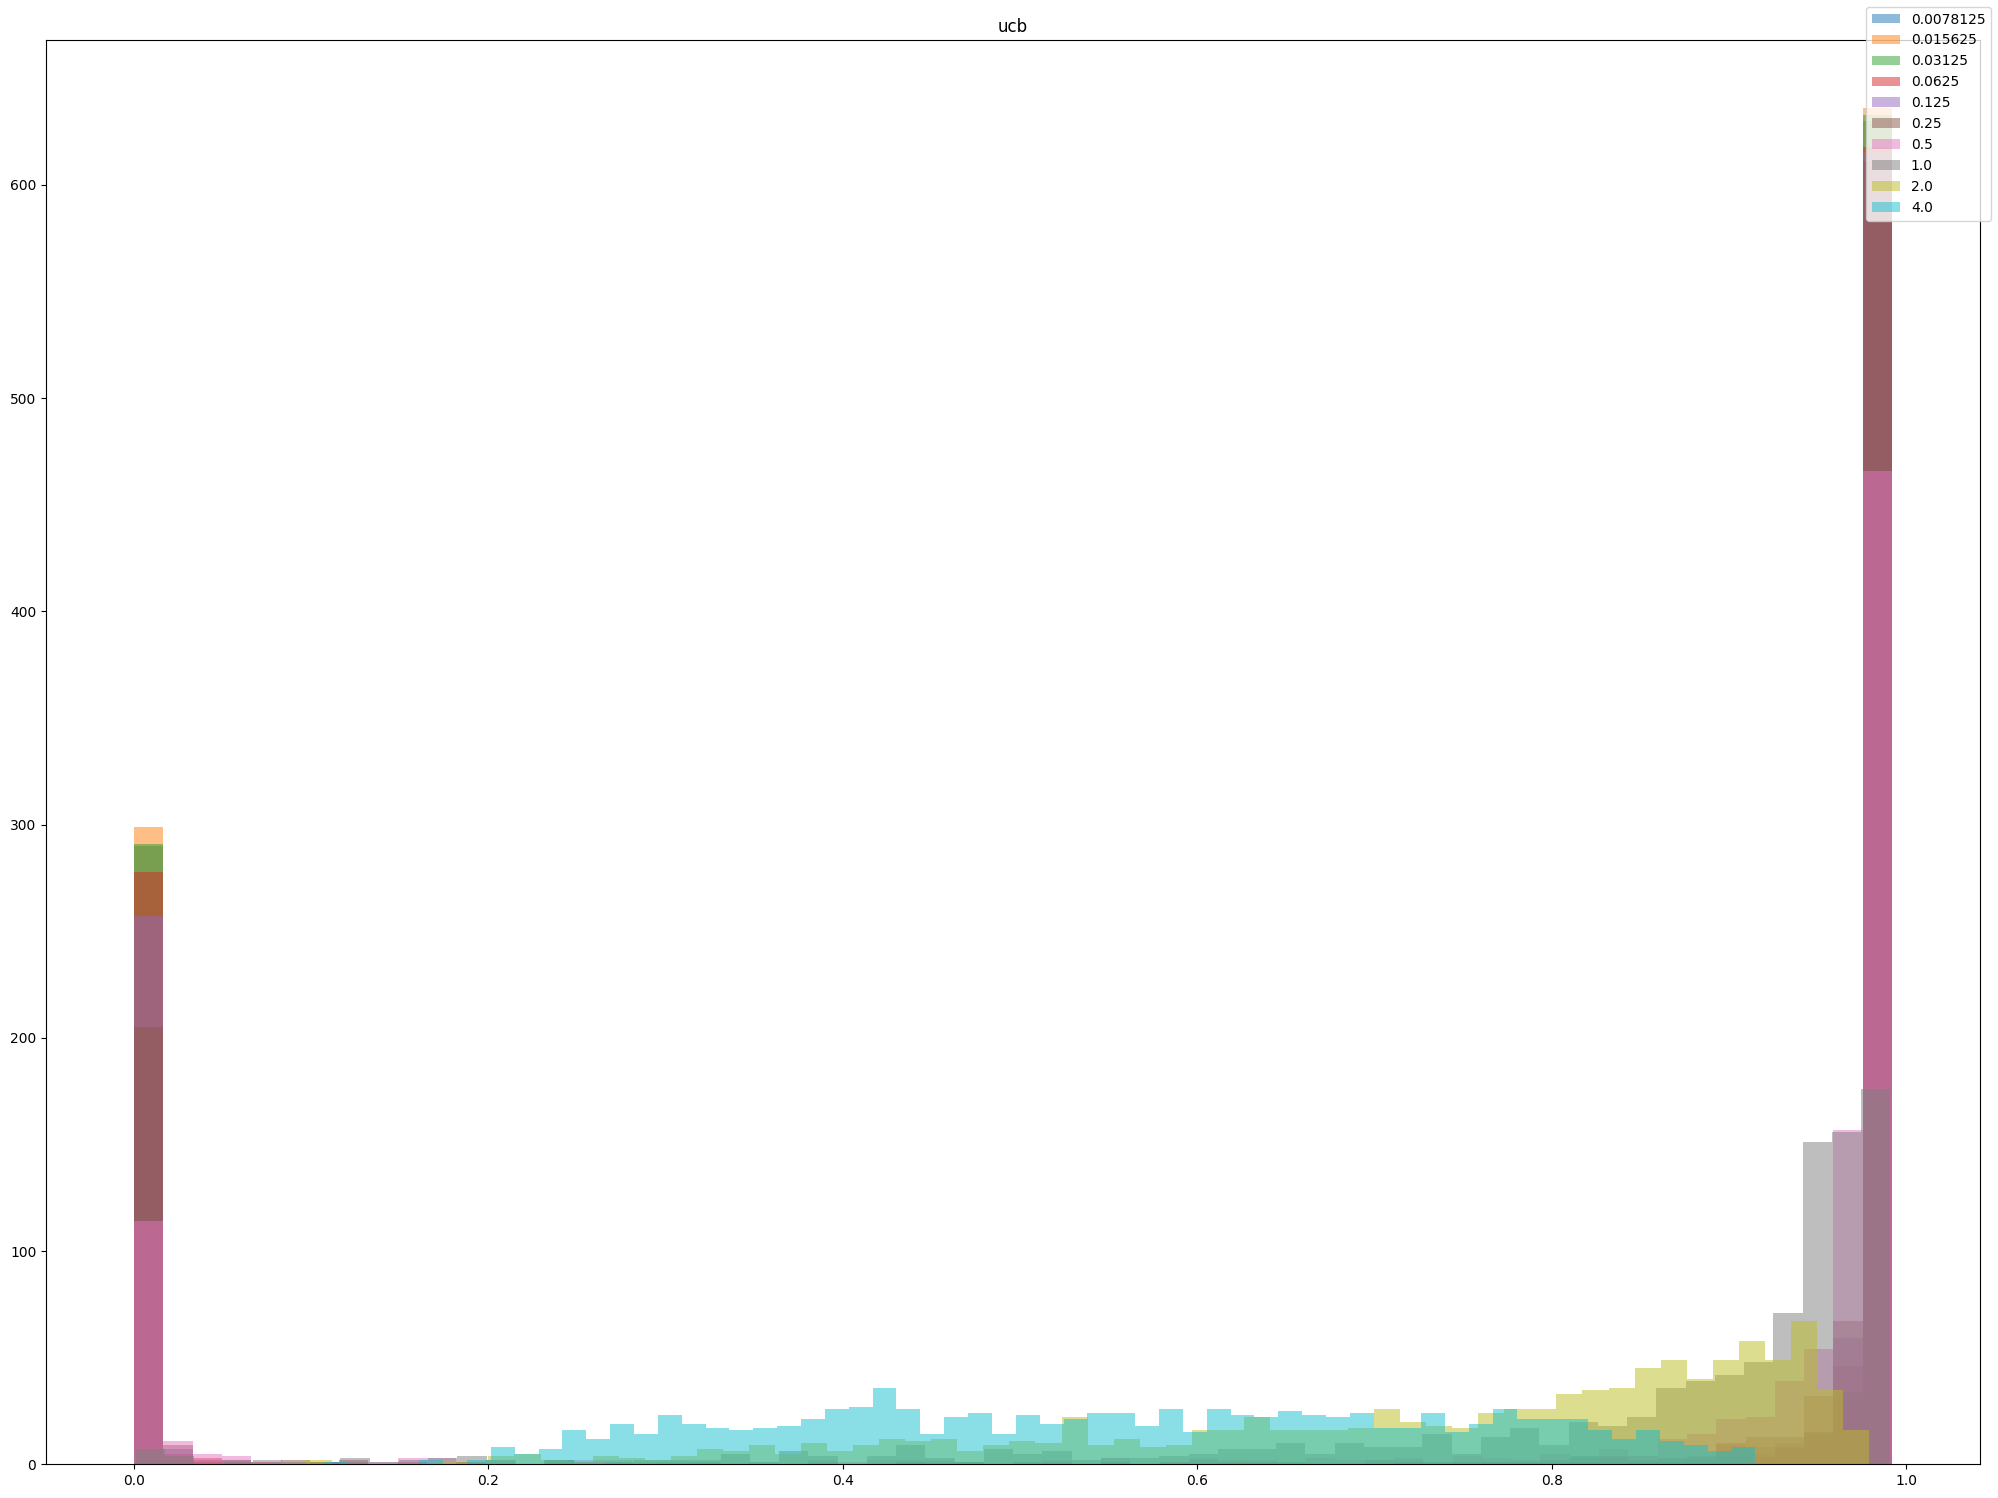

In [6]:
cols = meanChoicesExp[0].columns
params = meanChoicesExp[0].index.values
hists = {}
import itertools
for i, choices in enumerate( meanChoicesExp ):
    for param, col in itertools.product(params, cols):
        if col not in hists.keys():
            hists[col] = {}
        colHist = hists[col]
        if param not in colHist.keys():
            colHist[param] = np.zeros( n_trials )
        hists[col][param][i] = choices.loc[param, col]

for col in cols:
    fig, ax = plt.subplots()
    results = hists[col]
    for param, res in results.items():
        ax.hist( res, bins = int( np.sqrt( n_trials ) / 2 ) * 4, label = param, alpha = .5 )
        print( col, param, np.quantile( res, [i * .25 for i in range( 0, 5 )]))
    ax.set_title( col )
    fig.legend()
    fig.tight_layout()
    plt.show()